# Purpose: Combine methane atmospheric concentration estimates from Julian years 1-2017, from references at the end of this notebook, and do a logistic fit to the year 200-1749 estimates

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import csv
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17CH4')

Read three input files separately and assign the year values and methane concentration data

In [2]:
df1 = pd.read_excel('cage17lawdome1-2004nov02_ud.xlsx')
df1.to_csv('cage17lawdome1-2004nov02_ud.csv',header=False,index=False)
df1 = pd.read_csv('cage17lawdome1-2004nov02_ud.csv')
df1.drop(df1.index[[-1]],inplace=True)
df1.drop(df1.columns[5], axis=1,inplace=True)

df2 = pd.read_excel('NOAA_MoleFractions_2016_ud.xlsx')
df2.to_csv('NOAA_MoleFractions_2016_ud.csv',header=False,index=False)
df2 = pd.read_csv('NOAA_MoleFractions_2016_ud.csv')
df2.drop(df2.index[[-1]],inplace=True)

df3 = pd.read_excel('NOAAESRL.xlsx')
df3.to_csv('NOAAESRL.csv',header=False,index=False)
df3 = pd.read_csv('NOAAESRL.csv')
df3.drop(df3.index[[-1]],inplace=True)
df3.drop(df3.columns[2:6], axis=1,inplace=True)

Prepare for the nomenclature for the output excel sheet

In [3]:
out1 = 'heat';
out2 = 'ch4-1-2017';
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-') # split the date string we create by symbol "-"
yrs = str(int(date_split[0])-2000) # real years minus 2000 
seq = [out1, yrs, out2,months[int(date_split[1])-1],date_split[2]]
seperator = ','
filename = seperator.join(seq).replace(',', '')

Combine CH4 concentration estimates, after rescaling Law Dome to NOAA

In [4]:
yrslaw = df1.iloc[:,0:1]
newyrslaw = yrslaw['YearAD'].tolist()
newyrslaw = list(map(float, newyrslaw))
ch4law = df1.iloc[:, 2:3]
df1 = pd.merge(yrslaw,ch4law, left_index =True, right_index =True,how='outer')
df1 = df1.astype(float)
yrsnoaa = df2.iloc[:,0:1]
yrsnoaa = yrsnoaa['Year'].tolist()
yrsnoaa = list(map(float, yrsnoaa))
newyrsnoaa = [x -0.5 for x in yrsnoaa]
yrsnoaa = list(map(str, newyrsnoaa))
yrsnoaa = pd.DataFrame({'Year':yrsnoaa})
noaa = len(yrsnoaa)
ch4noaa = df2.iloc[:,2:3]
df2 = pd.merge(yrsnoaa,ch4noaa, left_index =True, right_index =True,how='outer')
df2 = df2.astype(float)
c1 = newyrsnoaa
c2 = newyrslaw
yrsboth = list(set(c1) & set(c2))
a = yrsboth[0]
b = yrsboth[-1]
ch4lawboth = ch4law[newyrslaw.index(a):newyrslaw.index(b)+1]
ch4noaaboth = ch4noaa[0:len(yrsboth)]
ch4noaaboth = ch4noaaboth['CH4'].tolist()
ch4noaaboth = list(map(float, ch4noaaboth))
ch4lawboth = ch4lawboth['NOAA04'].tolist()
ch4lawboth = list(map(float, ch4lawboth))
rescalelaw = ch4noaaboth[0]/ch4lawboth[0]
ratio2017vs2016 = float(df3.iloc[-1,-1])/float(df3.iloc[-2,-1])
yrs = list(range(1, 2018))
ch4law = ch4law.astype(float)
ch4law *= float(rescalelaw)
ch4law.drop(ch4law.index[-int((1+newyrslaw[-1]-newyrsnoaa[0])):-1],inplace=True,axis=0) 
ch4law = ch4law[:-1]
ch4law = ch4law['NOAA04'].tolist()
ch4law = list(map(float, ch4law))
ch4noaa = ch4noaa['CH4'].tolist()
ch4noaa = list(map(float, ch4noaa))
last = ratio2017vs2016*ch4noaa[-1]
last = [float(last)]
ch4 = ch4law + ch4noaa + last
# print (ch4)
ch4pre = ch4[yrs.index(200):yrs.index(1749)+1]
yrspre = range(200,1750)

[690.147357180993, 689.6209289909236, 688.9892151628403, 688.4627869727709, 687.9363587827015, 687.4099305926321, 686.7782167645488, 686.2517885744794, 685.7253603844099, 685.1989321943405, 684.6725040042711, 684.1460758142017, 683.6196476241323, 683.0932194340629, 682.5667912439935, 682.0403630539241, 681.5139348638547, 680.9875066737852, 680.5663641217297, 680.0399359316604, 679.6187933796049, 679.0923651895355, 678.6712226374799, 678.2500800854244, 677.723651895355, 677.3025093432994, 676.881366791244, 676.5655098772023, 676.1443673251468, 675.7232247730911, 675.4073678590496, 674.9862253069941, 674.6703683929524, 674.3545114789108, 674.0386545648691, 673.7227976508275, 673.4069407367858, 673.0910838227442, 672.8805125467164, 672.5646556326748, 672.354084356647, 672.1435130806193, 671.8276561665776, 671.6170848905499, 671.4065136145222, 671.1959423384943, 671.0906567004804, 670.8800854244528, 670.6695141484249, 670.564228510411, 670.3536572343834, 670.2483715963695, 670.143085958355

In [5]:
# with open("C:\\Users\\cd7\\Desktop\\Heat17CH4", 'w') as ch4concentration:
#     wr = csv.writer(ch4concentration, quoting=csv.QUOTE_ALL)
#     wr.writerow(ch4)

df5 = pd.DataFrame(ch4, columns=["concentration"])
df5.to_csv('list.csv', index=False)

Define the fitted logistic function and fit data

In [6]:
def logistic(yrspre,c0,c1,c2,c3):
     y = c1 / (1 + np.exp(-(yrspre-c2)/c3))+c0
     return y
param_bounds=([600,50,800,200],[700,70,900,300])
popt,pcov = curve_fit(logistic, yrspre, ch4pre, bounds=param_bounds)
print (popt)
print (popt[0]+popt[1])

[667.97873685  64.16012618 871.29482355 237.92447717]
732.1388630271916


Plot the fitted logistic function,comparing with the historical data and save the results as a csv file.

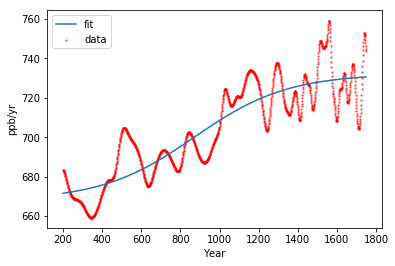

In [7]:
x = np.array(yrspre)
y = logistic(x, *popt)
plt.plot(x,y, label="fit")
plt.xlabel('Year')
plt.ylabel('ppb/yr') 
plt.scatter(yrspre,ch4pre,s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
plt.legend(loc='best')
plt.savefig('ch42.eps',dpi=1000)
plt.show()

yrs = list(map(str, yrs))
yrs = pd.DataFrame({'Year':yrs})
ch4 = list(map(str, ch4))
ch4 = pd.DataFrame({'CH4':ch4})
df = pd.merge(yrs, ch4, left_index =True, right_index =True,how='outer')
df.loc[-1]=['Julian','ppb']
df.index = df.index+1
df = df.sort_index()
df.loc[(len(df))] = ['2018/6/14','heat17ch4dec14.nb']
df.to_csv(filename + '.csv', index=False)